Package import

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

Data import

In [2]:
from google.colab import files
upload = files.upload()

Saving a_data.csv to a_data.csv


In [44]:
a_data = pd.read_csv('a_data.csv')

In [24]:
a_data.dtypes

date           object
sales_diff    float64
dtype: object

In [25]:
a_data.head()

,date,sales_diff
0,2013-02-01,4513.0
1,2013-03-01,157965.0
2,2013-04-01,64892.0
3,2013-05-01,80968.0
4,2013-06-01,32355.0


In [45]:
a_data = a_data.set_index('date')

In [46]:
a_data.index = pd.to_datetime(a_data.index)

# **SARIMAX Model**

Model score

In [47]:
scores = {}

In [53]:
a_data.head()

,sales_diff,forecast
date,,
2013-02-01,4513.0,NaN
2013-03-01,157965.0,NaN
2013-04-01,64892.0,NaN
2013-05-01,80968.0,NaN
2013-06-01,32355.0,NaN


In [49]:
def get_model_scores(data):    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    scores['ARIMA'] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }
    
    print("Model Score : ", scores)
    pickle.dump(scores, open( "scores.p", "wb" ))

SARIMAX Modeling

In [50]:
def sarimax_model(data):
    
    # Model
    smm = sm.tsa.statespace.SARIMAX(
        a_data.sales_diff, order=(12,0,0), 
        seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start = 40
    end = 100
    dynamic = 7

    data['forecast'] = smm.predict(start=start, end=end, dynamic=dynamic) 
    prediction_data = data.forecast[start+dynamic:end]
    data[['sales_diff', 'forecast']].plot(color=['Green', 'Red'])
    
    get_model_scores(data)
    return smm, data, prediction_data


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Model Score :  {'ARIMA': {'rmse': 14959.89346608319, 'mae': 11265.335748412077, 'r2': 0.9835642876238073}}


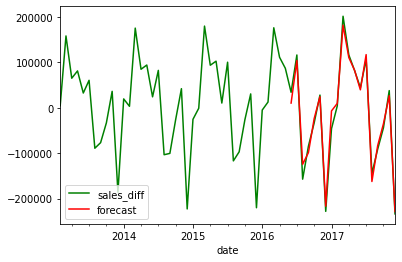

In [51]:
smm, s_data, predictions = sarimax_model(a_data)

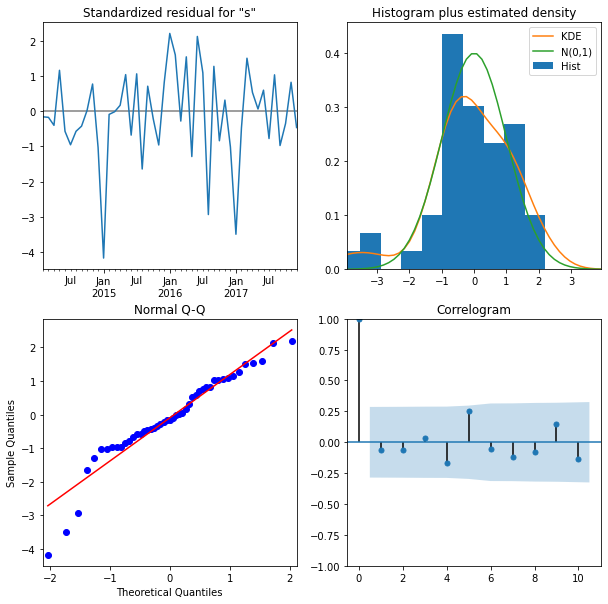

In [52]:
smm.plot_diagnostics(figsize=(10, 10));

## **Plot Predictions**

In [54]:
upload = files.upload()

Saving train.csv to train.csv


In [55]:
def predict_data(prediction_data):
    
    #load in original dataframe without scaling applied
    raw_data = pd.read_csv('train.csv')
    raw_data.date = raw_data.date.apply(lambda x: str(x)[:-3])
    raw_data = raw_data.groupby('date')['sales'].sum().reset_index()
    raw_data.date = pd.to_datetime(raw_data.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(raw_data[-13:].date)
    act_sales = list(raw_data[-13:].sales)
    
    for index in range(0,len(prediction_data)):
        prediction = {}
        prediction['pred_value'] = int(prediction_data[index] + act_sales[index])
        prediction['date'] = sales_dates[index+1]
        result_list.append(prediction)
        
    data_result = pd.DataFrame(result_list)
    
    return data_result, raw_data

In [56]:
def plot_predictions(predictions, raw_data, model_name):

    fig, axis = plt.subplots(figsize=(15,6))
    sns.lineplot(raw_data.date, raw_data.sales, data=raw_data, 
                 ax=axis, label='Original', color='Green')
    sns.lineplot(predictions.date, predictions.pred_value, data=predictions, 
                 ax=axis, label='Predicted', color='Red')
    
    axis.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    axis.legend()
    sns.despine()
    plt.savefig(f'output/{model_name}_forecast.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


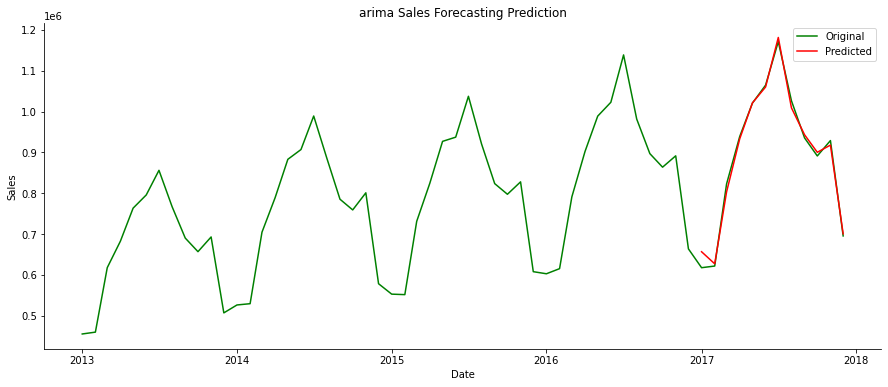

In [57]:
prediction_data, raw_data = predict_data(predictions)
plot_predictions(prediction_data, raw_data, 'arima')